\title{}
\author{}
\date{}
\maketitle

\thispagestyle{empty}
\vspace*{3cm}

\begin{center}
{\LARGE \textbf{Trabajo Individual}\par}
\vspace{0.3cm}
{\LARGE \textbf{Métodos Estadísticos en Minería de Datos}\par}

\vspace{0.8cm}
\rule{0.8\textwidth}{0.4pt}

\vspace{0.8cm}
{\large \textbf{Universidad Carlos III de Madrid}\par}
{\large \textbf{Grado en Estadística y Empresa}\par}

\vspace{1.2cm}
{\Large \textbf{Parte 1 – Problema de Regresión}\par}

\vspace{2cm}
{\Large \textbf{Alonso Velázquez Torres}\par}
\end{center}

\newpage

# Introducción al problema y conjunto de datos
Para esta primera mitad del trabajo final individual de la asignatura de Métodos estadísticos en minería de datos, se requiere resolver un problema de regresión, es decir, construir modelos de predicción para una variable respuesta numérica. En pos de este objetivo se ha seleccionado el dataset `Diamonds`, exploraremos su contenido a continuación pero antes explicaremos qué representa cada variable:

- *carat*: Peso del diamante (en quilates), numérica.
- *cut*: Calidad de la talla del diamante, categórica (de mejor a peor: Ideal, Premium, Very Good, Good, Fair).
- *color*: Color del diamante, categórica (de mejor a peor: D, E, F, G, H, I, J).
- *clarity*: Medida de pureza del diamante, categórica (de mejor a peor: IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1).
- *depth*: Profundidad relativa del diamante (altura del diamante entre diámetro promedio por cien), numérica.
- *table*: Porcentaje de anchura que supone la cara plana superior del diamante con respecto a la anchura total, numérica.
- *x*: Longitud (en milímetros), numérica. 
- *y*: Anchura (en milímetros), numérica.
- *z*: Profundidad (en milímetros), numérica.
- *price*: Precio del diamante (en USD), numérica.

He decidido trabajar con este conjunto de datos para resolver el problema de regresión debido a su idoneidad para esta tarea dada su variable respuesta de precio numérica, combinando además variables predictoras numéricas y categóricas que permiter poder aplicar una gran variedad de técnicas distintas para mejorar el ajuste del modelo, sumado a un creciente interés personal por la gemología.

Las principales hipótesis que surgen dada la naturaleza de este conjunto de datos, y que esperamos resolver con nuestro análisis son las siguientes:
¿Cuanto mayor sea el tamaño del diamante, más caro será? ¿El precio es afectado en mayor medida por las variables que hacen alusión al tamaño (*carat, x, y, z*) o a la calidad (*cut, color, clarity, depth, table*)? ¿Podemos distinguir distintos grupos de diamantes basados en la combinación de todas sus características?

# Exploración del conjunto de datos
Nuestro paso cero, antes de comenzar con la resolución del problema, consiste en comprender la naturaleza de nuestros datos, para ello llevaremos a cabo un análisis exploratorio de los datos (EDA), con las correspondientes visualizaciones que puedan resultar interesantes.

In [62]:
# comenzamos cargando las librerías que necesitaremos para toda esta parte
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
import gower
import kmedoids
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from mpl_toolkits.mplot3d import Axes3D

# establecemos también las semillas para controlar la aleatoriedad de nuestros modelos
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
# cargamos el conjunto de datos
diam = pd.read_csv('diamonds_regression.csv')

In [64]:
# comprobamos la forma, los tipos de datos y el aspecto del conjunto
print(diam.shape,'\n')
print(diam.dtypes,'\n')
diam.head()

(53940, 10) 

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object 



,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


Vemos que nuestro conjunto de datos es de gran tamaño, por lo que algunos procesos podrían darnos problemas de memoria con nuestro equipo informático. Sacaremos una muestra aleatoria y realizaremos el trabajo con ella.

In [65]:
diam = diam.sample(n=2000, random_state=42).reset_index(drop=True)
diam.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.24,Ideal,G,VVS1,62.1,56.0,3.97,4.00,2.47,559
1,0.58,Very Good,F,VVS2,60.0,57.0,5.44,5.42,3.26,2201
2,0.40,Ideal,E,VVS2,62.1,55.0,4.76,4.74,2.95,1238
3,0.43,Premium,E,VVS2,60.8,57.0,4.92,4.89,2.98,1304
4,1.55,Ideal,E,SI2,62.3,55.0,7.44,7.37,4.61,6901


In [66]:
# verificamos que no haya nulos ni filas duplicadas
print(diam.isnull().sum(),'\n')
print(diam.duplicated().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64 

1


Encontramos que hay un diamante que es igual a algún otro diamante del resto del dataset. Atendiendo a la naturaleza de los datos (7 variables numéricas continuas distintas y con precisión de medición considerablemente elevada en algunos casos), tenemos motivos suficientes para considerarlo un valor duplicado y no un diamante que ha resultado tener las mismas características que otro, por tanto lo descartamos.

In [67]:
diam = diam[~diam.duplicated()]

Encontramos que tras eliminar duplicados seguimos teniendo un dataset de tamaño suficiente para esta práctica.

In [68]:
diam.shape

(1999, 10)

Continuamos con el EDA.

In [69]:
# comprobamos el estado actual de nuestro conjunto después de las últimas modificaciones
print(diam.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    1999 non-null   float64
 1   cut      1999 non-null   object 
 2   color    1999 non-null   object 
 3   clarity  1999 non-null   object 
 4   depth    1999 non-null   float64
 5   table    1999 non-null   float64
 6   x        1999 non-null   float64
 7   y        1999 non-null   float64
 8   z        1999 non-null   float64
 9   price    1999 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 171.8+ KB
None


In [70]:
# obtenemos algunas métricas para las variables continuas y discretas
diam_cat = diam.select_dtypes('object')
diam_num = diam.select_dtypes('number')
print(diam_num.describe().T,'\n')
print(diam_cat.describe().T)

        count         mean          std     min     25%      50%       75%  \
carat  1999.0     0.801886     0.492106    0.23    0.39     0.70     1.040   
depth  1999.0    61.780390     1.409575   55.20   61.10    61.90    62.500   
table  1999.0    57.373187     2.290108   49.00   56.00    57.00    59.000   
x      1999.0     5.728759     1.156089    3.88    4.68     5.67     6.570   
y      1999.0     5.729655     1.150777    3.93    4.68     5.69     6.565   
z      1999.0     3.537964     0.709623    2.36    2.88     3.51     4.040   
price  1999.0  3963.946973  4124.241534  360.00  926.50  2322.00  5328.500   

            max  
carat      4.00  
depth     69.30  
table     73.00  
x         10.01  
y          9.94  
z          6.31  
price  18803.00   

        count unique    top freq
cut      1999      5  Ideal  818
color    1999      7      G  401
clarity  1999      8    SI1  453


Como último paso de la exploración del dataset, vamos a generar algunas visualizaciones para comprender mejor la naturaleza de los datos.

En este primer gráfico podemos ver gráficos de dispersión 2 a 2 para todas las combinaciones de variables numéricas posibles, donde en algunos casos observamos que es muy probable que esas dos variables estén correladas, esto tendremos que investigarlo con una matriz de correlaciones. También tenemos en la diagonal las distribuciones de cada variable numérica.

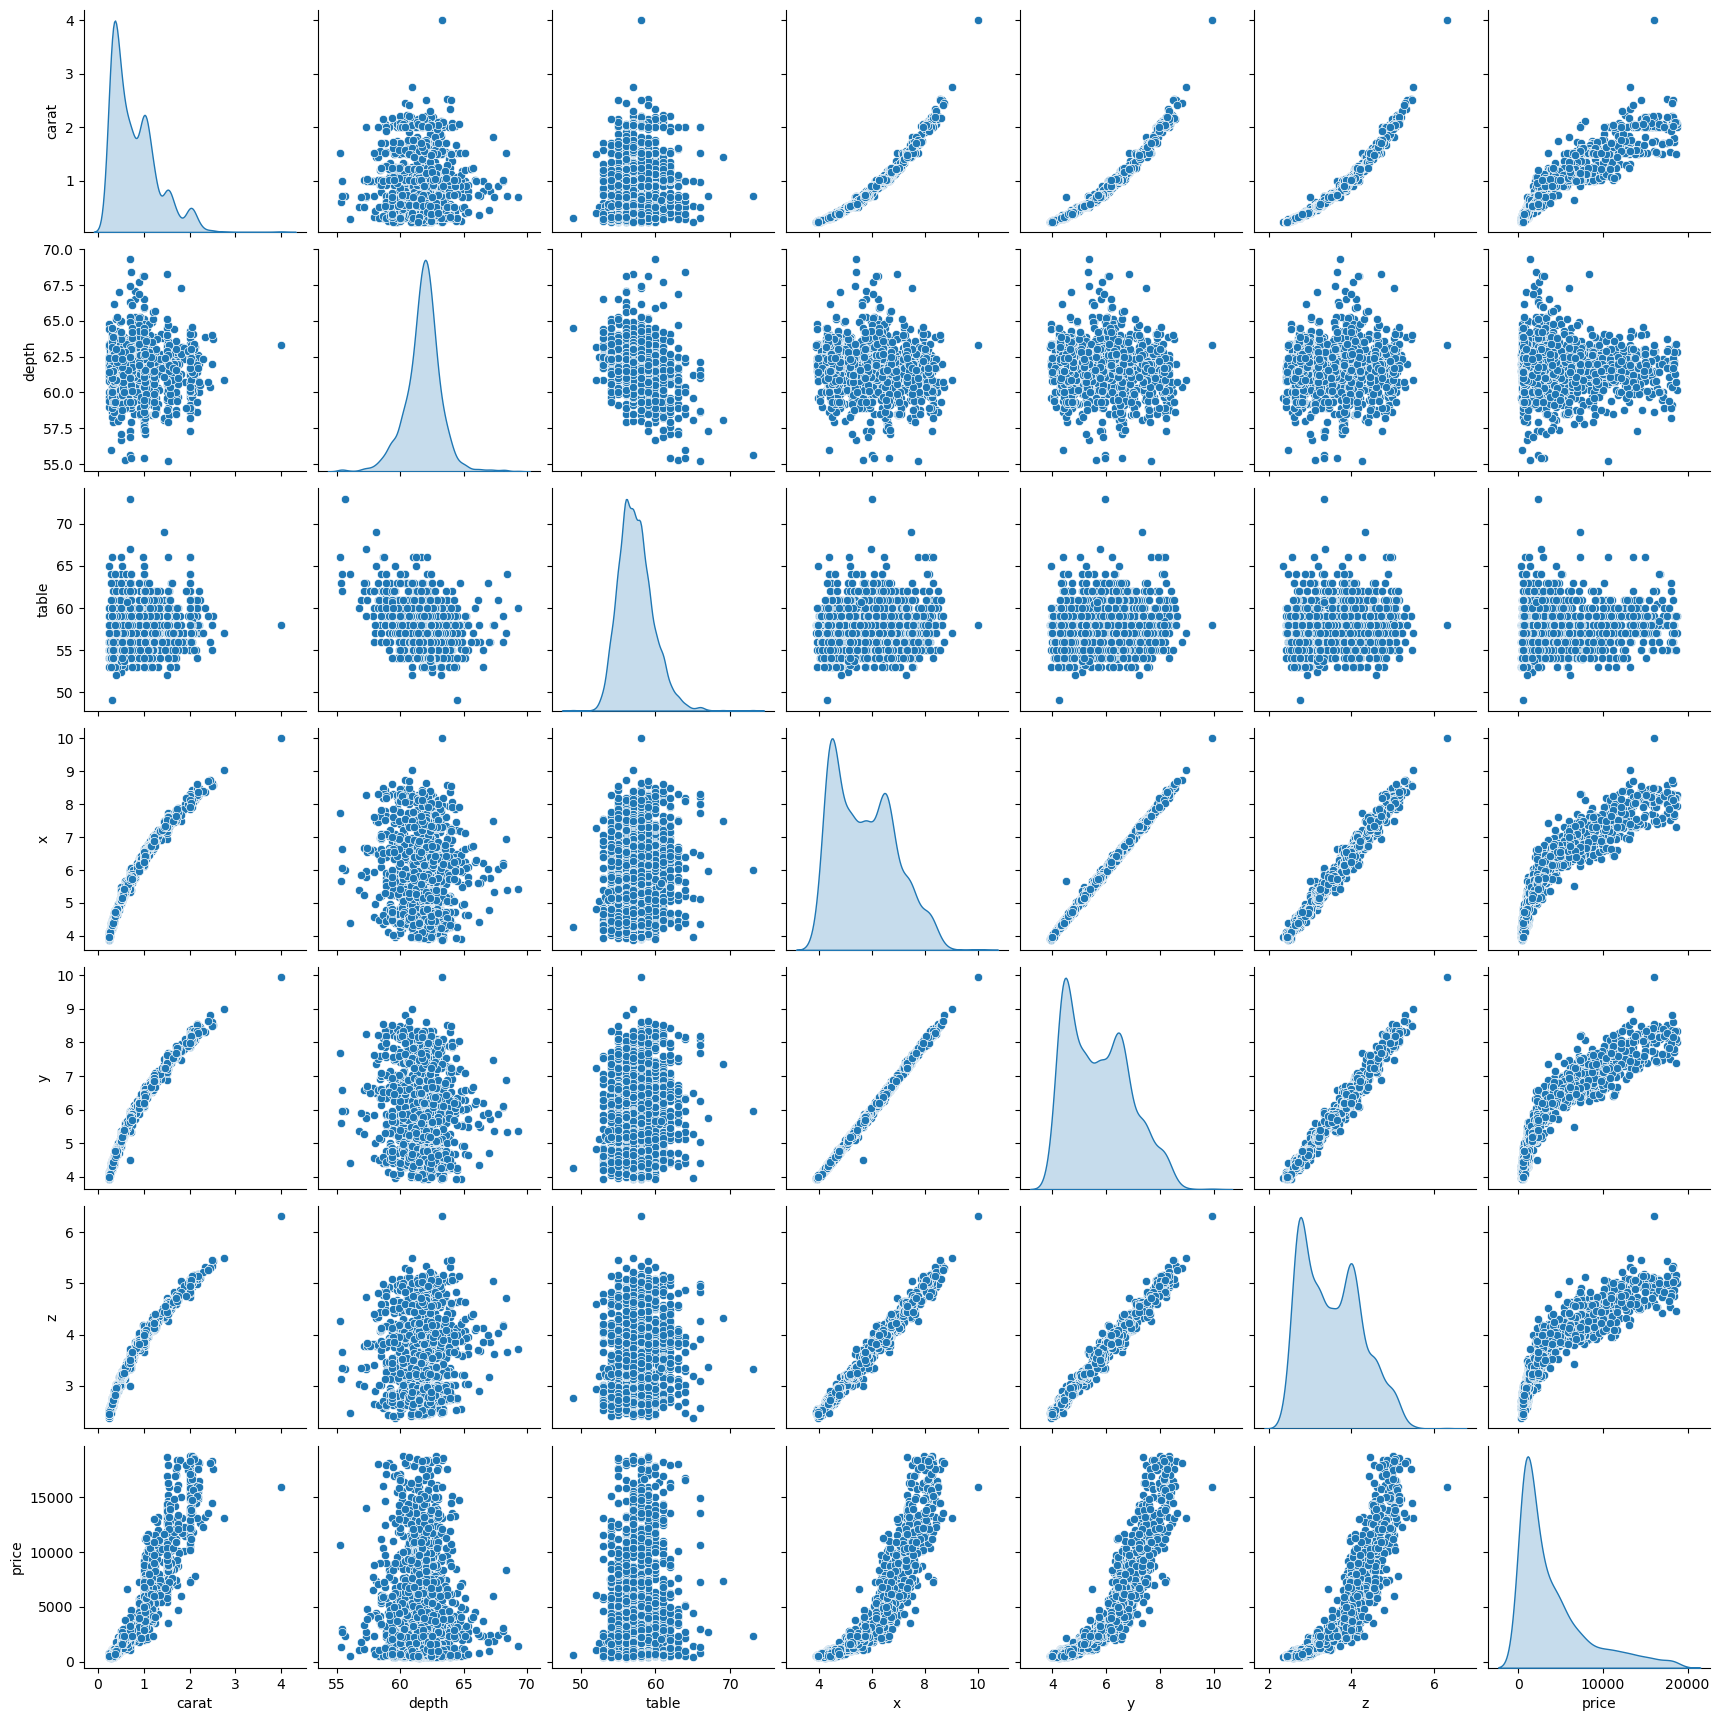

In [71]:
sns.pairplot(
    diam_num,
    diag_kind="kde"
)
plt.show()

A continuación, verificamos si existe correlación entre algunas variables con una matriz de correlación, como ayuda visual la graficaremos mediante un mapa de calor. Podemos ver que la longitud, la anchura, la profundidad, el precio y los quilates del diamante están todas extremadamente correladas entre sí, como es lógico, dado que todas hacen referencia al tamaño del diamante (de forma indirecta, pero evidente en el caso del precio). Teniendo estos resultados es posible que una técnica de reducción de dimensión nos sea útil más adelante.

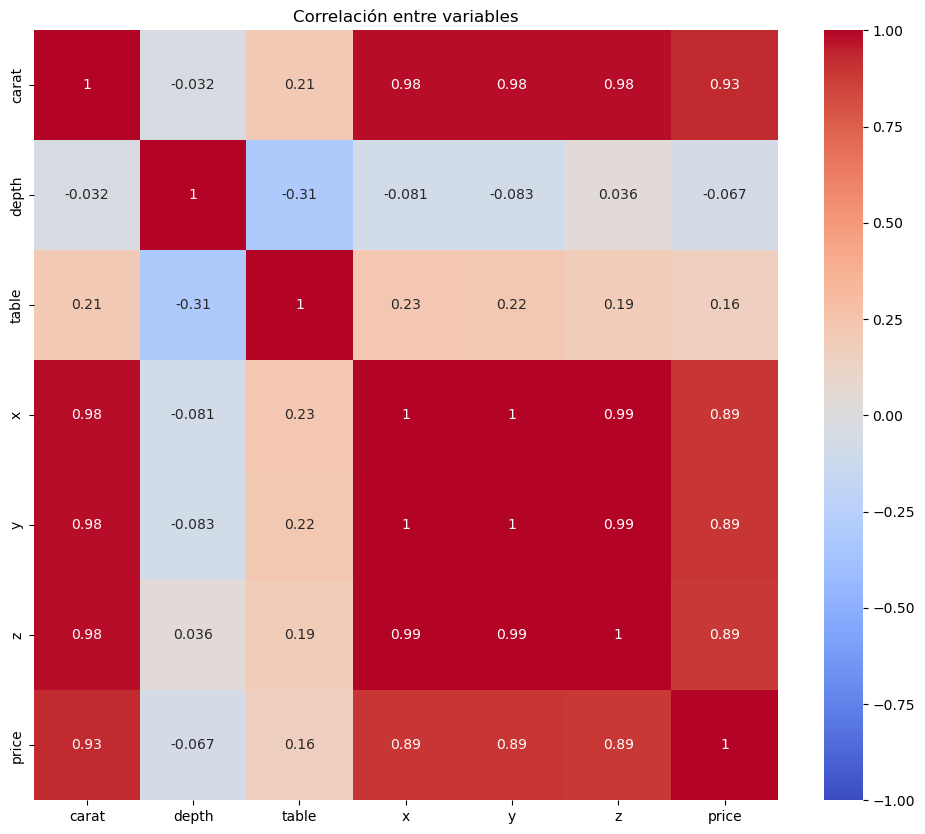

In [72]:
plt.figure(figsize=(12, 10))
sns.heatmap(diam_num.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.title("Correlación entre variables")
plt.show()

A continuación graficamos boxplots para las variables numéricas, que son otra forma de analizar la distribución de las variabes que hace más fácil detectar atípicos. Notamos que la gran varianza de la variable precio, al estar expresada en mayores unidades, provoca que esta domine el grafico, por lo que resulta imposible analizar el resto de variables. Probaremos a graficar las variables estandarizadas.

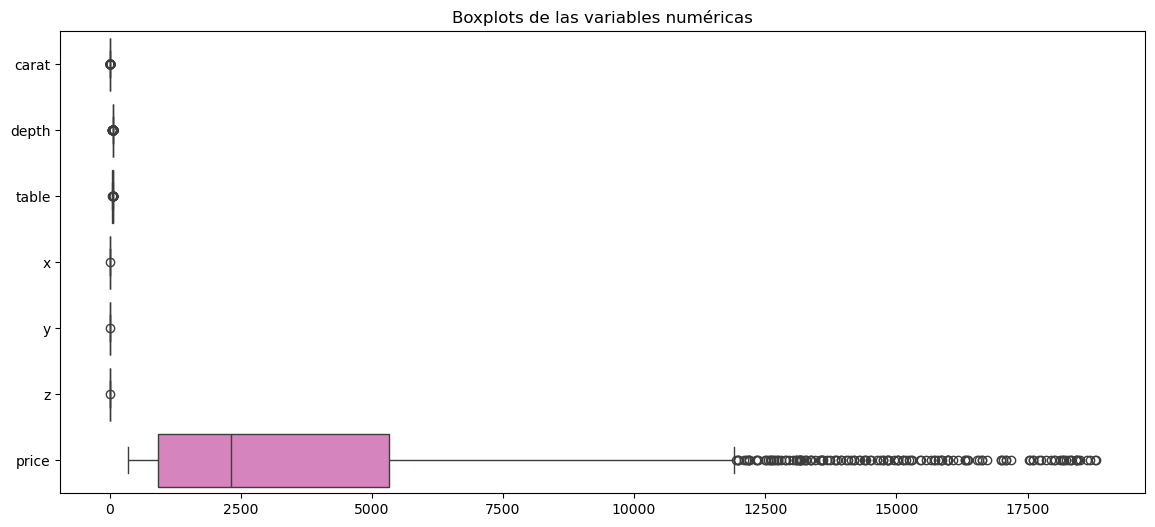

In [73]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=diam_num, orient="h")
plt.title("Boxplots de las variables numéricas")
plt.show()

De esta manera, podemos analizar mejor la distribución de cada variable (aunque no en sus unidades originales) y sus atípicos. Encontramos que en general los atípicos parecen naturales y no fruto de algún error de imputación.

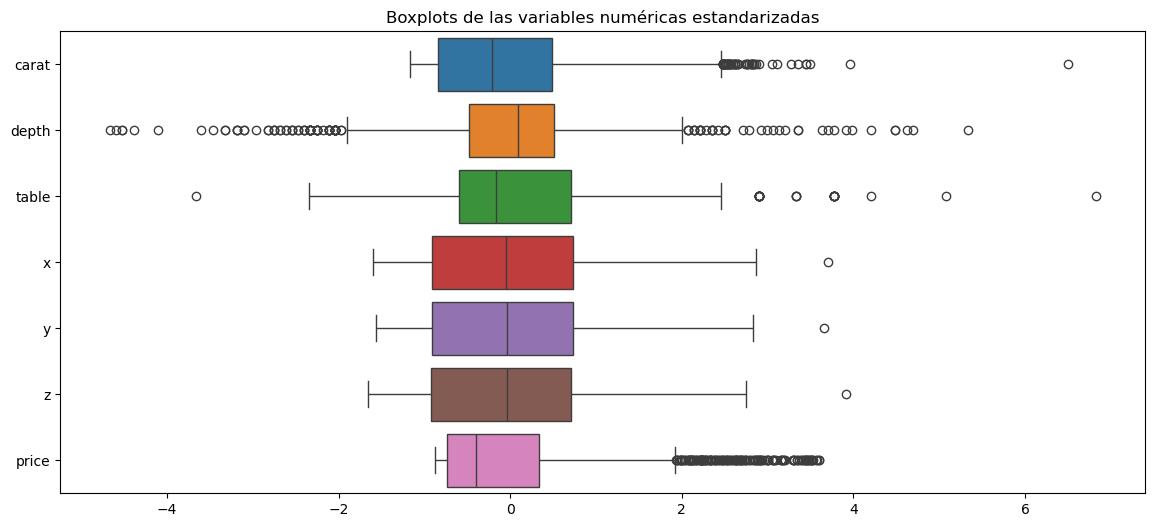

In [74]:
scaler = StandardScaler()

diam_num_scaled = pd.DataFrame(
    scaler.fit_transform(diam_num),
    columns=diam_num.columns,
    index=diam_num.index
)

plt.figure(figsize=(14, 6))
sns.boxplot(data=diam_num_scaled, orient="h")
plt.title("Boxplots de las variables numéricas estandarizadas")
plt.show()

Terminamos la exploración con algunas visualizaciones más.

Aquí podemos comprobar como el tamaño afecta muy claramente al precio del diamante.

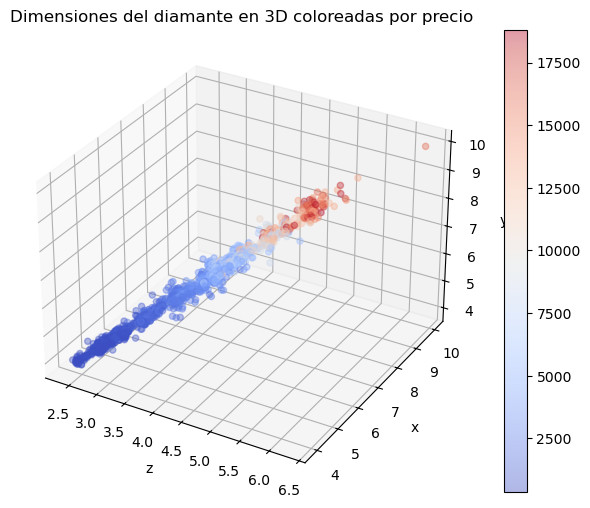

In [75]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(diam["z"], diam["x"], diam["y"], c=diam["price"], cmap="coolwarm", alpha=0.4)
ax.set_xlabel("z"); ax.set_ylabel("x"); ax.set_zlabel("y")
plt.title("Dimensiones del diamante en 3D coloreadas por precio")
plt.colorbar(p)
plt.show()

En el siguiente gráfico, vemos cómo el color influye claramente en el precio (graficado contra el corte), sin embargo nos damos cuenta de que son los peores colores los que están alcanzando un mayor precio, similarmente vemos que el mejor corte es el que tiene el precio medio más bajo. Debemos investigar por qué sucede esto.

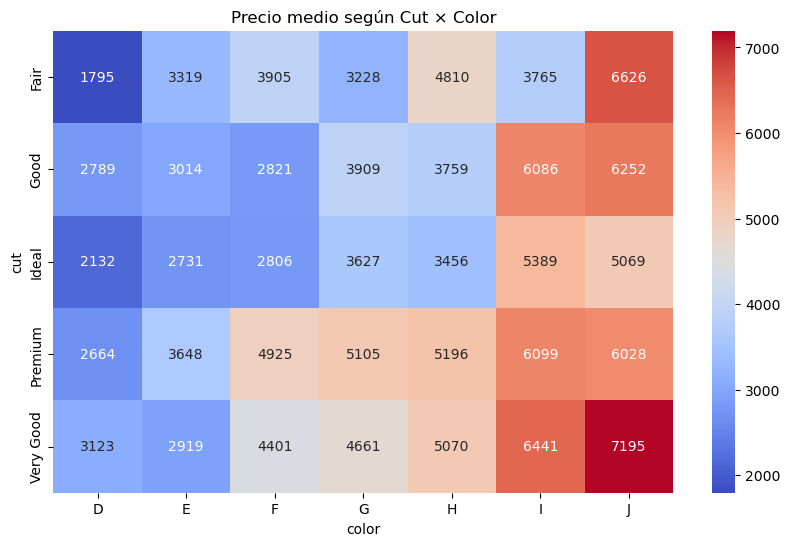

In [76]:
pivot = diam.pivot_table(values="price", index="cut", columns="color", aggfunc="mean")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Precio medio según Cut × Color")
plt.show()

Mediante una rápida comprobación determinamos que esto sucede debido a que los mejores cortes y colores pertenecen a diamantes más pequeños (más refinados), es decir que los diamantes de mayor tamaño son más bastos. Esto nos ayuda a comprender que el tamaño de un diamante tiene prioridad sobre su calidad para determinar su precio (hasta cierto punto, véase que el corte premium tiene el mayor precio medio a pesar de ser más pequeños de media que los de corte fair).

In [77]:
diam.groupby('cut').mean('price')

,carat,depth,table,x,y,z,price
cut,,,,,,,
Fair,0.970781,63.534375,59.610937,6.129531,6.075000,3.868125,3897.531250
Good,0.826612,62.444809,58.216940,5.761639,5.771913,3.597596,3744.081967
Ideal,0.703215,61.712592,55.919927,5.499487,5.509499,3.396198,3377.009780
Premium,0.890473,61.276529,58.769231,5.976647,5.941124,3.649665,4645.408284
Very Good,0.849813,61.960890,57.802576,5.799485,5.830445,3.601874,4383.384075


In [78]:
diam.groupby('color').mean('price')

,carat,depth,table,x,y,z,price
color,,,,,,,
D,0.605948,61.831897,57.454741,5.266810,5.269440,3.256466,2571.577586
E,0.658308,61.667179,57.429231,5.396487,5.398974,3.325949,3068.758974
F,0.732717,61.705163,57.332880,5.597120,5.596467,3.451929,3663.135870
G,0.786733,61.794264,57.115212,5.706683,5.708454,3.525461,4218.586035
H,0.892410,61.729967,57.531596,5.952964,5.948599,3.670912,4418.390879
I,1.119215,62.076440,57.434031,6.401728,6.400366,3.972094,5718.246073
J,1.207182,61.900909,57.530000,6.607727,6.619909,4.091909,5838.090909


Graficamos ahora la distribución del precio de los diamantes según la pureza del diamante. No se observa que a mayor pureza mayor precio debido al motivo anterior, el factor (oculto en este caso) del tamaño es más determinante.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13084\2654208207.py:2: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



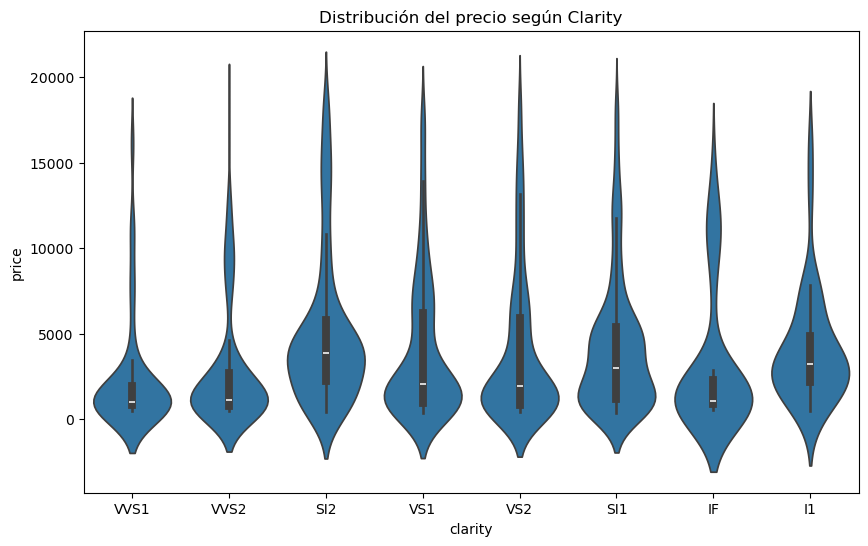

In [79]:
plt.figure(figsize=(10,6))
sns.violinplot(x="clarity", y="price", data=diam, inner="box", scale="width")
plt.title("Distribución del precio según Clarity")
plt.show()

In [80]:
diam.groupby('clarity').mean('carat')

,carat,depth,table,x,y,z,price
clarity,,,,,,,
I1,1.289444,62.233333,58.447222,6.782222,6.736111,4.203611,4059.000000
IF,0.553729,61.635593,56.491525,5.072373,5.088983,3.131864,3186.915254
SI1,0.873598,62.007726,57.493598,5.934768,5.929448,3.676578,4201.024283
SI2,1.056756,61.764611,57.856300,6.361609,6.353298,3.923619,5019.227882
VS1,0.741561,61.630565,57.266113,5.613123,5.619136,3.459568,3975.299003
VS2,0.762831,61.717123,57.425799,5.619110,5.623037,3.467648,3967.196347
VVS1,0.484179,61.773881,56.632090,4.881866,4.891194,3.016493,2311.776119
VVS2,0.545171,61.628293,56.822439,5.083610,5.099220,3.136146,2783.253659


Finalmente mejoramos el gráfico en 3D para hacerlo interactivo. De esta manera podemos ver el gran impacto que el tamaño supone para el precio.

In [81]:
fig = px.scatter_3d(
    diam,
    x="x", y="y", z="z",
    color="price",
    size="price",
    size_max=20,  # tamaño máximo de los marcadores
    color_continuous_scale="Viridis",
    opacity=1,
    hover_data=["carat", "cut", "color", "clarity", "price"]
)

fig.update_layout(
    title="Gráfico 3D interactivo - Tamaño de los diamantes<br><sup>Color y tamaño según precio</sup>",
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="z"
    )
)

fig.show()

# Resolución del problema de regresión
Es importante destacar el hecho de que la variable que trataremos de predecir, el precio, no debe incluirse al aplicar las técnicas de clustering o reducción de la dimensión para evitar fuga de información.

Nuestro enfoque de cara a la resolución del problema de regresión será: Primero, aplicar técnicas de reducción de la dimensión para nuestro conjunto de datos, al ser de tipo de datos mixto (numéricas y categóricas) aplicaremos PCA sobre las 6 numéricas, extrayendo un número determinado de componentes principales y uniéndolos a las 3 variables categóricas en un nuevo dataset. Segundo, realizaremos K-medoids con este nuevo dataset (mediante una matriz de distancias Gower) y comprobaremos si arroja resultados concluyentes. Finalmente, se construirá un modelo de árbol de regresión y una red neuronal para el dataset original y otro de cada tipo para el nuevo dataset, además en caso de que el K-medoids haya sido un éxito, se aplicará la técnica que haya tenido mejor rendimiento promedio (árbol o red neuronal), y se aplicará a cada cluster obtenido analizándose si esto mejora los resultados.

Los árboles para los problemas de clasificación y regresión serán construidos utilizando técnicas vistas en esta asignatura en conjunto con las vistas en la asignatura de Aprendizaje automático para el análisis de datos, también impartida este cuatrimestre.

Comenzamos con la reducción de dimensiones. Es práctica estándar llegar al 85% de la variabilidad explicada de modo que ese será nuestro objetivo.

In [82]:
# las variables numéricas deben estar estandarizadas para que ninguna domine los componentes 
# a razón de estar medida en unidades más elevadas
PCAdata = diam_num_scaled.drop(columns='price')

pca = PCA(n_components=6)
PCAcoords = pca.fit_transform(PCAdata)

PCAcoords = pd.DataFrame(
    PCAcoords,
    columns=[f"PC{i+1}" for i in range(PCAcoords.shape[1])]
)

print(PCAcoords.head(),'\n')
print("Varianza explicada:", pca.explained_variance_ratio_,'\n')
print("Varianza acumulada:", pca.explained_variance_ratio_.cumsum())


        PC1       PC2       PC3       PC4       PC5       PC6
0 -2.900947  0.206662 -0.064491  0.307709 -0.011630 -0.012873
1 -0.644232 -0.922228 -0.913667 -0.116604  0.016624  0.016810
2 -1.811111  0.639288 -0.482643  0.017368  0.019931 -0.000823
3 -1.464078 -0.599256 -0.468300 -0.012808  0.022244  0.012970
4  2.772217  1.330605 -0.755182  0.053551  0.043662  0.013139 

Varianza explicada: [6.70562003e-01 2.11477209e-01 1.12637984e-01 5.05596760e-03
 2.10868433e-04 5.59687190e-05] 

Varianza acumulada: [0.670562   0.88203921 0.9946772  0.99973316 0.99994403 1.        ]


Para alcanzar el 85% de la variabilidad explicada basta con seleccionar los dos primeras componentes principales. Vamos a crear el nuevo dataset.

In [83]:
PCAcoords = PCAcoords[['PC1','PC2']]
KMdata = pd.concat(
    [diam_cat.reset_index(drop=True),
     PCAcoords.reset_index(drop=True)],
    axis=1
)
KMdata.head()

,cut,color,clarity,PC1,PC2
0,Ideal,G,VVS1,-2.900947,0.206662
1,Very Good,F,VVS2,-0.644232,-0.922228
2,Ideal,E,VVS2,-1.811111,0.639288
3,Premium,E,VVS2,-1.464078,-0.599256
4,Ideal,E,SI2,2.772217,1.330605


Analizando los dos componentes principales que hemos seleccionado, vemos que PC1 está fuertemente influenciado por las variables de dimensiones y peso del diamante, mientras que PC2 está muy positivamente influenciado por depth y muy negativamente por table. En otras palabras, PC1 es un componente de tamaño y PC2 es un componente de proporciones del diamante.

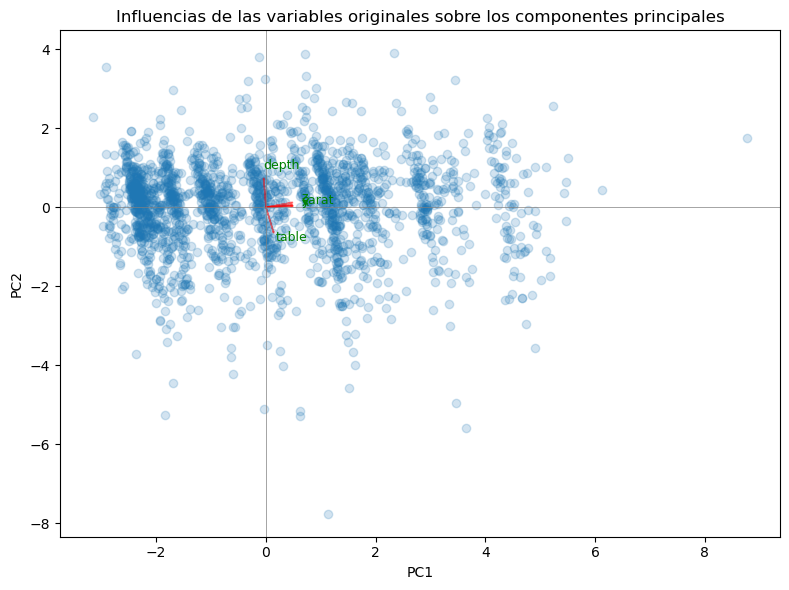

In [84]:
plt.figure(figsize=(8, 6))

# Puntos (observaciones)
plt.scatter(PCAcoords["PC1"], PCAcoords["PC2"], alpha=0.2)

# Vectores de las variables originales
for i, variable in enumerate(PCAdata.columns):
    plt.arrow(0, 0,
              pca.components_[0, i],
              pca.components_[1, i],
              color='r',
              alpha=0.5,
              head_width=0.03,
              length_includes_head=True)
    plt.text(pca.components_[0, i] * 1.3,
             pca.components_[1, i] * 1.3,
             variable,
             color='g',
             fontsize=9)

plt.title("Influencias de las variables originales sobre los componentes principales")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.tight_layout()
plt.show()

Vamos a utilizar K-medoids a partir de la matriz de distancias de Gower porque este método permite agrupar adecuadamente datos mixtos, combinando variables numéricas y categóricas en una única medida de similitud. A diferencia de K-means, que requiere medias y distancias euclídeas (incompatibles con categorías), K-medoids trabaja con cualquier matriz de distancias y selecciona como centro un medoide, que es una observación real, siendo además más robusto a outliers. La distancia de Gower permite medir las distancias entre individuos definidos por una mezcal de variables numéricas y categóricas.

Utilizaremos el método de iniciación *build*, que usa la heurística inteligente de PAM para elegir buenos medoides iniciales.

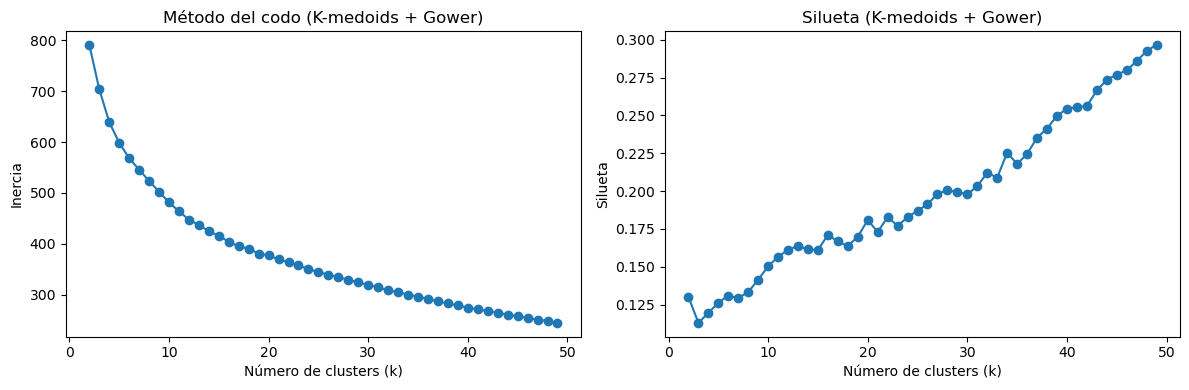

In [85]:
# obtenemos la matriz de distancias de Gower, que trabaja con numéricas y categóricas al mismo tiempo
dist_gower = gower.gower_matrix(KMdata)

ks = range(2, 50)
inertias = []
silhouettes = []

for k in ks:
    kmed = kmedoids.KMedoids(n_clusters=k, metric='precomputed', init='build', max_iter=300, random_state=42)
    kmed.fit(dist_gower)
    labels = kmed.labels_

    inertias.append(kmed.inertia_)

    sil_score = silhouette_score(dist_gower, labels, metric='precomputed')
    silhouettes.append(sil_score)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo (K-medoids + Gower)")

plt.subplot(1, 2, 2)
plt.plot(ks, silhouettes, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silueta")
plt.title("Silueta (K-medoids + Gower)")

plt.tight_layout()
plt.show()

Podemos ver que no existe un codo claro y que la silueta no deja de aumentar a medida que aumenta el valor de k, casi linealmente. Esto nos indica que nuestro conjunto de datos no posee una estructura de clusters clara. Esto es suficiente para detenernos aquí, sabemos que no será útil dividir nuestros individuos en grupos, pero vamos a graficar para k = 6 (valor arbitrario) la dispersión de los individuos en PC1 x PC2 (únicas variables numéricas de nuestro dataset nuevo) para observar cómo se comporta la división en clusters.

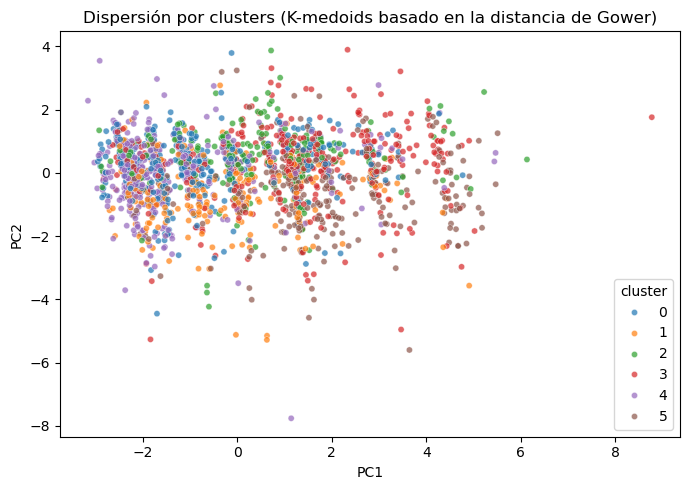

In [86]:
best_k = 6

kmed_final = kmedoids.KMedoids(n_clusters=best_k, metric='precomputed', init='build', random_state=42)
kmed_final.fit(dist_gower)
labels_final = kmed_final.labels_

KMdata_clustered = KMdata.copy()
KMdata_clustered["cluster"] = labels_final

num_cols = KMdata_clustered[['PC1','PC2']]

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=KMdata_clustered,
    x=num_cols['PC1'],
    y=num_cols['PC2'],
    hue="cluster",
    palette="tab10",
    s=20,
    alpha=0.7
)

plt.title("Dispersión por clusters (K-medoids basado en la distancia de Gower)")
plt.tight_layout()
plt.show()

Como hemos podido ver, la técnica utilizada de clustering no ha arrojado resultados concluyentes, por tanto se construirán cuatro modelos, un árbol y una red neuronal para el dataset original, y otro árbol y red neuronal para el nuevo dataset construido con las variables categóricas y los dos primeros componentes principales de las variables numéricas.

Primero modelaremos ambos árboles de regresión. Dividiremos los conjuntos de datos en un 80% para entrenamiento, y un 20% para test, además dentro del conjunto de entrenamiento haremos validación cruzada de 5 capas para obtener los mejores valores para los siguientes hiperparámetros:

- *max_depth*: Profundidad máxima del árbol.
- *min_samples_split*: número mínimo de muestras necesarias para dividir un nodo.
- *min_samples_leaf*: número mínimo de muestras que debe tener una hoja para que la división que la creó sea válida.

Para evaluar los árboles utilizaremos el R^2 y el RMSE.

Comenzamos con el árbol para el dataset original.

In [87]:
X = diam.drop(columns=["price"])
y = diam["price"]

numeric_features = diam_num.drop(columns=["price"]).columns
categorical_features = diam_cat.columns

# creamos el preprocesador para manipular las columnas numéricas y categóricas por separado,
# en el momento en que instanciemos el momento, por ahora este paso, así como el de la pipeline, es declarativo
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        # utilizamos OrdinalEncoder ya que el árbol de sklearn no puede trabajar con las categorías naturales, tienen que
        # estar codificadas con números (auqneu este modelo no aprende ordinalidad esta codificación es mejor que OHE,
        # que genera muchas variables nuevas por los dummies)
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)
    ]
)

# realizamos el split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# introducimos el preprocesador dentro de la pipeline e instanciamos el algoritmo
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("reg", DecisionTreeRegressor(random_state=42))
])

# instanciamos el grid de hiperparámetros con algunso valores sobre los que iteraremos para encontrar los mejores
param_grid = {
    "reg__max_depth": [None, 2, 3, 4, 5, 10, 20],
    "reg__min_samples_split": [2, 5, 10, 20],
    "reg__min_samples_leaf": [1, 2, 5, 10]
}

# instanciamos el método de validación interna
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2", # comparamos modelos en función de R^2
    n_jobs=-1 # utilizamos todos los núcleos disponibles
)

# entrenamos
grid.fit(X_train, y_train)

# extraemos los mejores valores para los hiperparámetros y las métricas en train
# (rmse es mejor para el rendimiento de un modelo y R^2 es mejor para comparar modelos)
print("Mejores hiperparámetros:")
print(grid.best_params_)
best_model = grid.best_estimator_

# obtenemos las predicciones dentro del propio train para evaluar el overfitting
y_pred_train = best_model.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")
print(f"R² train:   {r2_train:.4f}")

# realizamos las predicciones en test
y_pred_test = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"RMSE test: {rmse_test:.2f}")
print(f"R² test:   {r2_test:.4f}")

Mejores hiperparámetros:
{'reg__max_depth': None, 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 10}
RMSE train: 546.08
R² train:   0.9821
RMSE test: 1150.66
R² test:   0.9272


Obtenemos muy buenos resultados, con una reducción en el rendimiento de train a test de aproximadamente el 7%, lo que indica que existe overfitting pero no preocupante, el rendimiento en test sigue siendo muy alto. Por otro lado tenemos que el RMSE de train a test se duplica, sin embargo sigue siendo un valor razonable teniendo en cuenta que el precio medio es de casi 4000, con una desviación típica de más de 4000. Consideramos que se trata de un buen modelo. Grafiquemos el árbol para ver su forma.

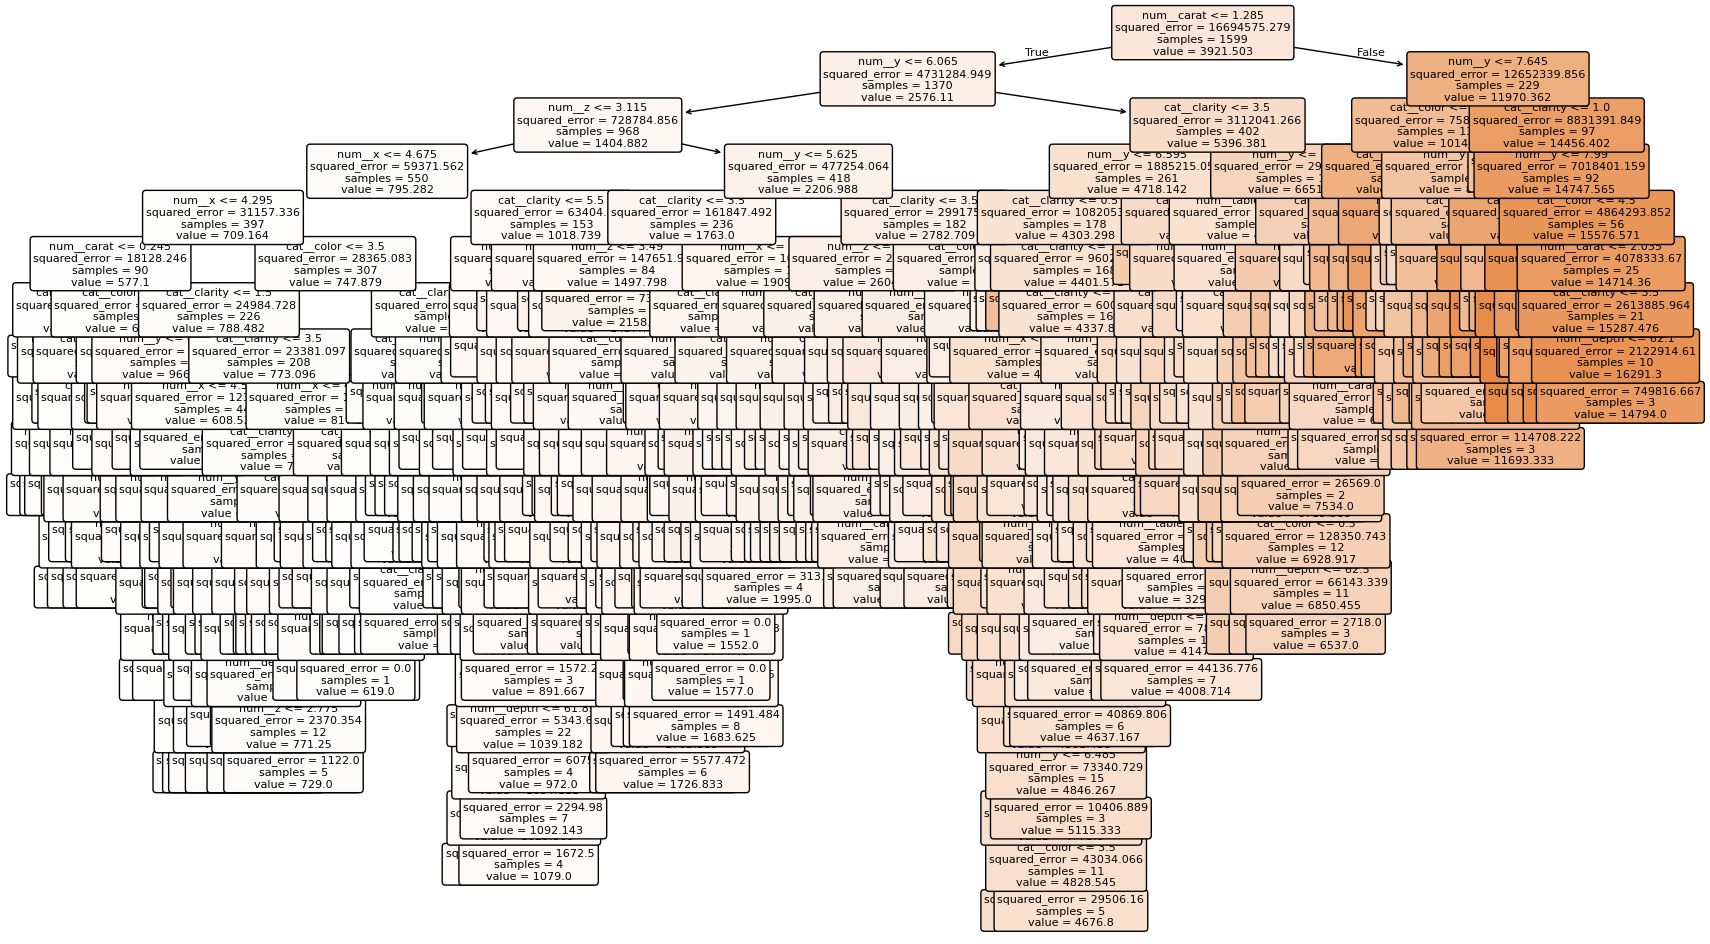

In [88]:
tree = best_model.named_steps["reg"]

plt.figure(figsize=(20, 12))
plot_tree(
    tree,
    filled=True,
    feature_names = best_model.named_steps["preprocess"].get_feature_names_out(),
    rounded=True,
    fontsize=8
)
plt.show()

In [89]:
profundidad_maxima = tree.get_depth()
print("Profundidad máxima del árbol:", profundidad_maxima)

Profundidad máxima del árbol: 19


Aunque en general los árboles se destacan por su explicabilidad, en casos como este, donde poseen gran profundidad, dicha ventaja se pierde. Aún así podemos ver que las variables que más influyen para las predicciones son *y*, *clarity*, *x* y *color*.

De manera similar, vamos a construir el árbol para el nuevo dataset de dimensión reducida.

In [90]:
X = KMdata

numeric_features = ["PC1", "PC2"]
categorical_features = diam_cat.columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
         categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("reg", DecisionTreeRegressor(random_state=42))
])

param_grid = {
    "reg__max_depth": [None, 2, 3, 4, 5, 10, 20],
    "reg__min_samples_split": [2, 5, 10, 20],
    "reg__min_samples_leaf": [1, 2, 5, 10]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(grid.best_params_)

best_model = grid.best_estimator_

y_pred_train = best_model.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")
print(f"R² train:   {r2_train:.4f}")

y_pred_test = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"RMSE test:  {rmse_test:.2f}")
print(f"R² test:    {r2_test:.4f}")

Mejores hiperparámetros:
{'reg__max_depth': 10, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 5}
RMSE train: 457.27
R² train:   0.9875
RMSE test:  1126.24
R² test:    0.9303


Tenemos un rendimiento extremadamente similar tanto en train como en test, con un R^2 en test ligeramente superior pero seguramente no lo suficiente como para considerarlo una diferencia significativa. Donde sí notamos una diferencia es en la selección de hiperparámetros, vemos que tenemos, en general, un árbol bastante más simple ya que teniendo las mismas posibilidades de valores para los hiperparámetros, ha seleccionado valores más simples (mayores o menores según el caso). Veámoslo.

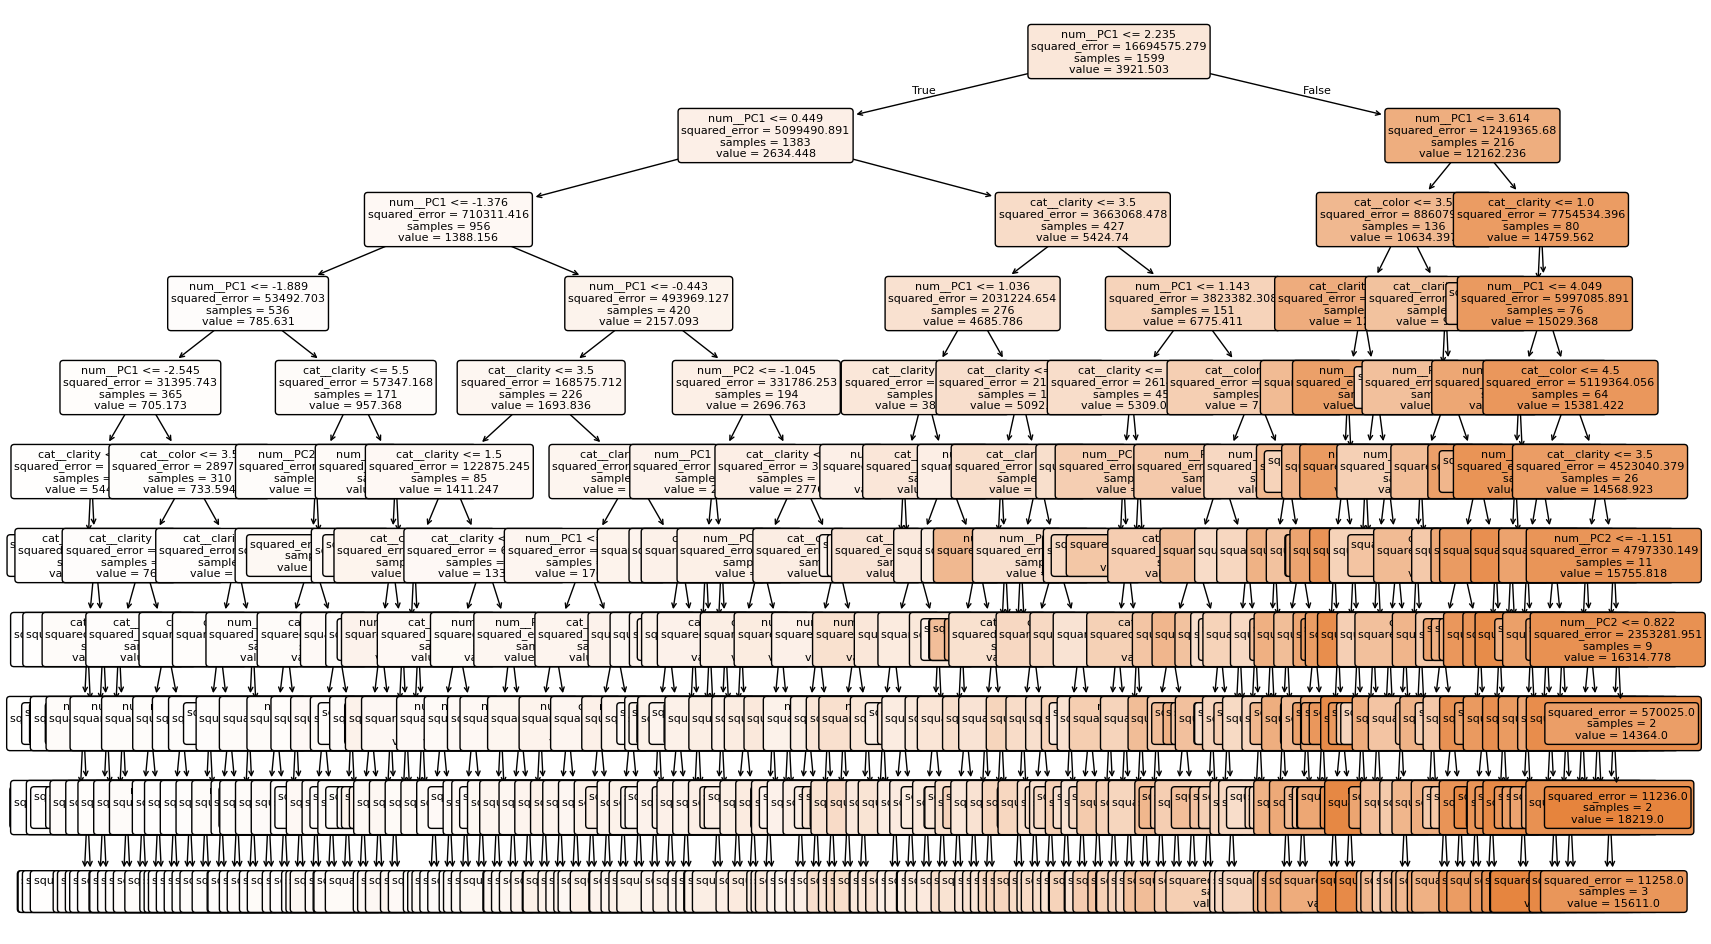

In [91]:
tree = best_model.named_steps["reg"]

plt.figure(figsize=(20, 12))
plot_tree(
    tree,
    filled=True,
    feature_names = best_model.named_steps["preprocess"].get_feature_names_out(),
    rounded=True,
    fontsize=8
)
plt.show()

Aunque sigue estando lejos de ser fácilmente explicable, sí podemos ver que el dataset de dimensión reducida ha resultado en un modelo de árbol de regresión más sencillo. Esto presenta una clara ventaja respecto al anterior a nivel computacional y de interpretabilidad. Como podríamos esperar, *PC1* es la variable que más impacto tiene en la toma de decisiones, sin embargo no seguida de *PC2*, sino de *clarity* y *color* que también resultaban importantes en el árbol del dataset original.

Construimos ahora la red neuronal para el dataset original. Dividiremos entrenamiento y test en 80/20 como antes, pero esta vez en lugar de validación cruzada, estableceremos el 20% del conjunto de entrenamiento como validación interna del modelo.

Tenemos a continuación los gráficos de la evolución tanto de la función de pérdida elegida (MSE), como la de ganancia (R2), que son las métricas utilizadas para evaluar el rendimiento de la red neuronal. Tras estos tenemos el gráfico del ajuste de las predicciones del modelo, en formato regresión, antes de leer ninguna cifra exacta de las métricas, visualmente ya podemos apreciar que se trata de un gran modelo, aunque a medida que el precio real del diamante aumenta es menos preciso con la correspondiente predicción.

In [92]:
# tenemos que volver a crear estos objetos debido a que en el segundo árbol se han sobreescrito con los del nuevo dataset
X = diam.drop(columns=["price"])
y = diam["price"].values

numeric_features = diam_num.drop(columns=["price"]).columns
categorical_features = diam_cat.columns

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# en la red neuronal es aún mejor utilizar el OrdinalEncoder dado que su algoritmo sí es capaz de capturar
# la ordinalidad inherente de todas nuestras variables categóricas, cuya jerarquía debemos establecer primero
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_order = ["J", "I", "H", "G", "F", "E", "D"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

categorical_transformer = Pipeline(
    steps=[
        ("ordinal",OrdinalEncoder(
                    categories=[cut_order, color_order, clarity_order],
                    handle_unknown="use_encoded_value",
                    unknown_value=-1
                ))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocess_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess)
    ]
)

X_train_proc = preprocess_pipe.fit_transform(X_train_raw)
X_test_proc = preprocess_pipe.transform(X_test_raw)

diam_model = keras.Sequential(
    [
        keras.layers.Input(shape=(X_train_proc.shape[1],)),
        # normalizamos las activaciones internas para estabilizar su distribución
        # hace que la red converga más rápido y sea menos sensible a la inicialización
        # evita que algunas neuronas tengan valores sistemáticamente mayores a otras
        keras.layers.BatchNormalization(),
        # usaremos relu ya que es sencilla, es la práctica estándar para capas ocultas
        # implementamos también la regularización L2 para evitar sobreajuste (penaliza crecimiento elevado de los pesos)
        keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.BatchNormalization(),
        # utilizamos dropout para que el modelo no dependa demasiado de un grupo concreto de neuronas
        # cada batch interactua con una versión ligeramente distinta de la red
        # con un 10% de dropout es suficiente, ya estamos usando L2, simplemente ayuda un poco más a evitar sobreajuste
        keras.layers.Dropout(0.1),
        keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1)
    ]
)

diam_model.summary()

diam_model.compile(
    # establecemos un learning rate bajo para mayor convergencia y estabilidad
    # además como hemos utilizado técnicas de regularización en la red, la superficie de
    # pérdida es más suave y delicada, necesitamos LR más bajo
    optimizer=keras.optimizers.Adam(learning_rate=0.003),
    loss="mse",
    metrics=[
        keras.metrics.R2Score(name="R2"),
        keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

diam_es = keras.callbacks.EarlyStopping(
    # si detectamos 20 épocas sin mejora detiene el entrenamiento y restaura los mejores valores
    patience=20,
    restore_best_weights=True,
    monitor="val_loss" # rmse en nuestro caso
)

history_diam = diam_model.fit(
    X_train_proc,
    y_train,
    validation_split=0.2,
    epochs=200,
    # establecemos mini-batches pequeños, no tenemos demasiados datos para una red neuronal
    batch_size=16,
    callbacks=[diam_es],
    verbose=1
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197 (47.64 KB)

 Trainable params: 11,923 (46.57 KB)

 Non-trainable params: 274 (1.07 KB)

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - R2: -0.6773 - loss: 26822572.0000 - rmse: 5179.0513 - val_R2: 0.0991 - val_loss: 17547260.0000 - val_rmse: 4188.9448
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.7709 - loss: 3664061.0000 - rmse: 1914.1737 - val_R2: 0.7041 - val_loss: 5763909.5000 - val_rmse: 2400.8145
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.8343 - loss: 2650394.7500 - rmse: 1628.0033 - val_R2: 0.8510 - val_loss: 2902443.5000 - val_rmse: 1703.6559
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.8581 - loss: 2268773.2500 - rmse: 1506.2448 - val_R2: 0.8840 - val_loss: 2258858.5000 - val_rmse: 1502.9500
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.8666 - loss: 2133707.0000 - rmse: 1460.7214 - val_R2: 0.8933 - val_loss: 2077297.2500 - val_rmse: 1441.2832
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.8703 - loss: 2074201.2500 - rmse: 1440.2087 - val_R2: 0.9166 - val_loss: 1624978.2500 - val_rmse: 1274.

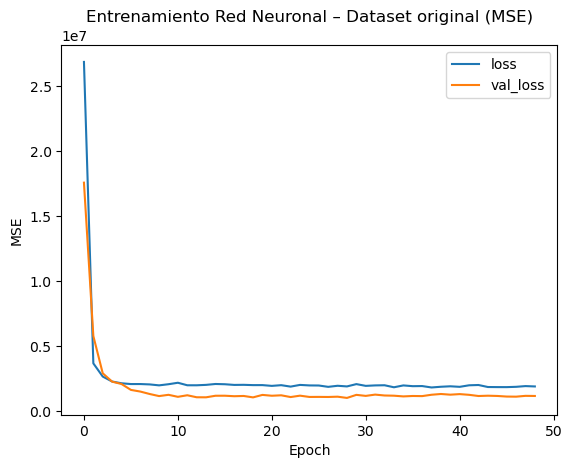

In [93]:
history_df = pd.DataFrame(history_diam.history)

history_df[["loss", "val_loss"]].plot(title="Entrenamiento Red Neuronal – Dataset original (MSE)")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

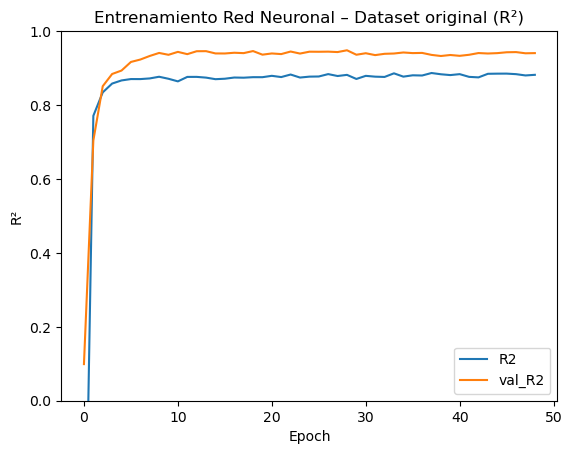

In [94]:
history_df[["R2", "val_R2"]].plot(title="Entrenamiento Red Neuronal – Dataset original (R²)")
plt.ylabel("R²")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

Train MSE:  824210.81 | R²: 0.95 | RMSE:  907.86
Test MSE:  1164988.38 | R²: 0.94 | RMSE:  1079.35
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


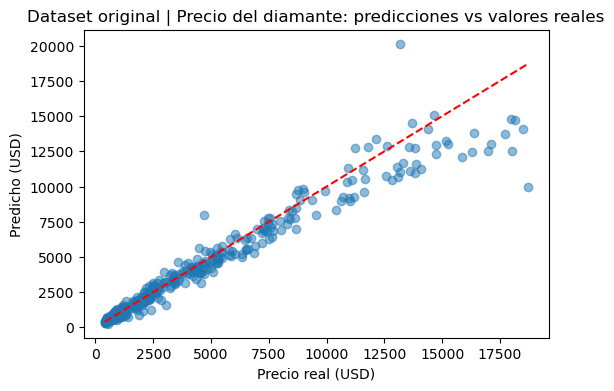

,Precio real,Predicción
0,4490,5656.842773
1,2441,2763.850830
2,492,748.135193
3,15272,13017.444336
4,838,897.918152
5,475,504.200043
6,5179,4595.669434
7,3438,3050.639893
8,516,574.383118
9,13869,11598.849609


In [95]:
diam_eval_train = diam_model.evaluate(X_train_proc, y_train, verbose=0)
print(
    f"Train MSE:  {diam_eval_train[0]:.2f} | "
    f"R²: {diam_eval_train[1]:.2f} | "
    f"RMSE:  {diam_eval_train[2]:.2f}"
)

diam_eval_test = diam_model.evaluate(X_test_proc, y_test, verbose=0)
print(
    f"Test MSE:  {diam_eval_test[0]:.2f} | "
    f"R²: {diam_eval_test[1]:.2f} | "
    f"RMSE:  {diam_eval_test[2]:.2f}"
)

diam_predictions = diam_model.predict(X_test_proc).flatten()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, diam_predictions, alpha=0.5)
plt.xlabel("Precio real (USD)")
plt.ylabel("Predicho (USD)")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
)
plt.title("Dataset original | Precio del diamante: predicciones vs valores reales")
plt.show()

comparison = pd.DataFrame(
    {
        "Precio real": y_test,
        "Predicción": diam_predictions,
    }
)
comparison.head(10)

Comprobamos que el sobreajuste es casi inexistente, sobre todo comparado con las métricas en train y test que obteníamos del árbol del dataset original. Se trata, como cabría esperar, de un mejor modelo que el árbol, sin embargo es muy difícilmente interpretable y posee un mayor coste computacional.

Computaremos ahora la red neuronal homóloga para el dataset de dimensión reducida. De nuevo, comenzamos con los mismos tres gráficos que en el caso anterior, donde ya podemos ver que esta segunda red neuronal ha tenido un rendimiento muy similar a la anterior.

In [96]:
X = KMdata
y = diam["price"].values

numeric_features = ["PC1", "PC2"]
categorical_features = diam_cat.columns

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# dado que las variables numéricas son componentes principales en este caso, no es necesario estandarizar

cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_order = ["J", "I", "H", "G", "F", "E", "D"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

categorical_transformer = Pipeline(
    steps=[
        ("ordinal",OrdinalEncoder(
                    categories=[cut_order, color_order, clarity_order],
                    handle_unknown="use_encoded_value",
                    unknown_value=-1
                ))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

preprocess_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess)
    ]
)

X_train_proc = preprocess_pipe.fit_transform(X_train_raw)
X_test_proc = preprocess_pipe.transform(X_test_raw)

KMdata_model = keras.Sequential(
    [
        keras.layers.Input(shape=(X_train_proc.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1)
    ]
)

KMdata_model.summary()

KMdata_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.003),
    loss="mse",
    metrics=[
        keras.metrics.R2Score(name="R2"),
        keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

KMdata_es = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    monitor="val_loss"
)

history_KMdata = KMdata_model.fit(
    X_train_proc,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[KMdata_es],
    verbose=1
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_14          │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,669 (45.58 KB)

 Trainable params: 11,403 (44.54 KB)

 Non-trainable params: 266 (1.04 KB)

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - R2: -0.6496 - loss: 26379722.0000 - rmse: 5136.1191 - val_R2: 0.0092 - val_loss: 19296810.0000 - val_rmse: 4392.8135
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2: 0.7901 - loss: 3356831.2500 - rmse: 1832.1658 - val_R2: 0.5319 - val_loss: 9116584.0000 - val_rmse: 3019.3682
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2: 0.8204 - loss: 2872837.7500 - rmse: 1694.9447 - val_R2: 0.6845 - val_loss: 6145037.0000 - val_rmse: 2478.9185
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.8318 - loss: 2690215.5000 - rmse: 1640.1876 - val_R2: 0.8055 - val_loss: 3787620.5000 - val_rmse: 1946.1810
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2: 0.8565 - loss: 2294168.2500 - rmse: 1514.6511 - val_R2: 0.8586 - val_loss: 2754578.2500 - val_rmse: 1659.6923
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2: 0.8602 - loss: 2235891.5000 - rmse: 1495.2897 - val_R2: 0.8924 - val_loss: 2094796.7500 - val_rmse: 1447.

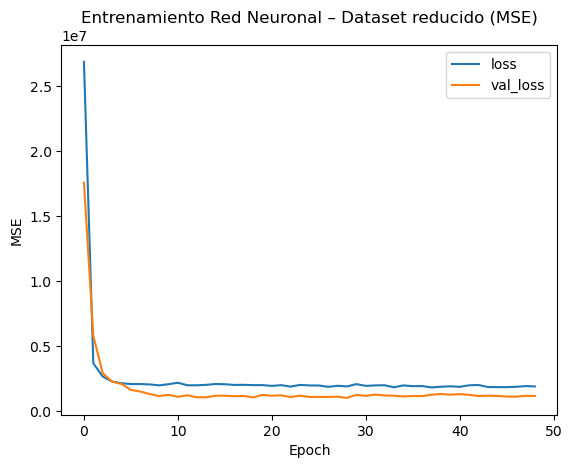

In [97]:
history_KMdata = pd.DataFrame(history_KMdata.history)

history_df[["loss", "val_loss"]].plot(title="Entrenamiento Red Neuronal – Dataset reducido (MSE)")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

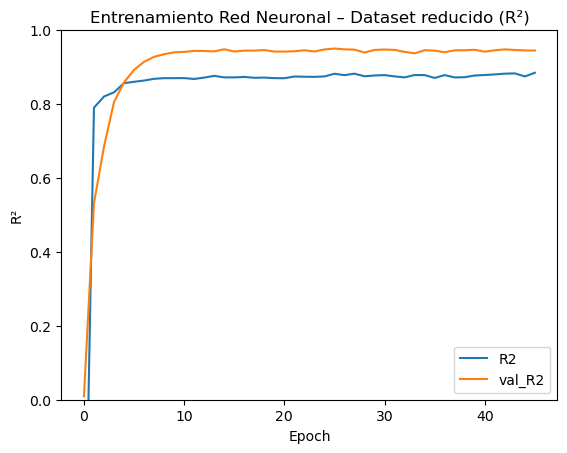

In [98]:
history_KMdata[["R2", "val_R2"]].plot(title="Entrenamiento Red Neuronal – Dataset reducido (R²)")
plt.ylabel("R²")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

Train MSE:  769928.94 | R²: 0.95 | RMSE:  877.46
Test MSE:  1119357.25 | R²: 0.94 | RMSE:  1058.00
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


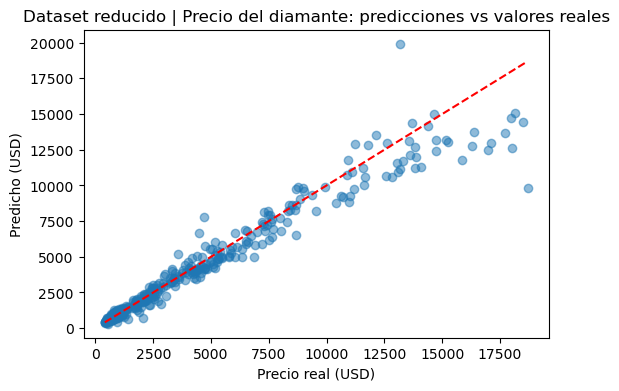

,Precio real,Predicción
0,4490,6655.058105
1,2441,2832.339844
2,492,707.719238
3,15272,13028.597656
4,838,987.452209
5,475,454.746368
6,5179,4218.138672
7,3438,2950.094971
8,516,501.376984
9,13869,11970.241211


In [99]:
KMdata_eval_train = KMdata_model.evaluate(X_train_proc, y_train, verbose=0)
print(
    f"Train MSE:  {KMdata_eval_train[0]:.2f} | "
    f"R²: {KMdata_eval_train[1]:.2f} | "
    f"RMSE:  {KMdata_eval_train[2]:.2f}"
)

KMdata_eval_test = KMdata_model.evaluate(X_test_proc, y_test, verbose=0)
print(
    f"Test MSE:  {KMdata_eval_test[0]:.2f} | "
    f"R²: {KMdata_eval_test[1]:.2f} | "
    f"RMSE:  {KMdata_eval_test[2]:.2f}"
)

KMdata_predictions = KMdata_model.predict(X_test_proc).flatten()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, KMdata_predictions, alpha=0.5)
plt.xlabel("Precio real (USD)")
plt.ylabel("Predicho (USD)")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
)
plt.title("Dataset reducido | Precio del diamante: predicciones vs valores reales")
plt.show()

comparison = pd.DataFrame(
    {
        "Precio real": y_test,
        "Predicción": KMdata_predictions,
    }
)
comparison.head(10)

Observamos que el rendimiento de la red neuronal con el dataset reducido es prácticamente indistinguible del rendimiento de la anterior red neuronal, incluso en este caso la reducción de dimensionalidad ni siquiera conlleva una menor carga computacional, podemos ver que ejecutando las redes neuronales varias veces, la segunda no tarda un menor número de epochs en detenerse que la primera de manera consistente.

Del análisis realizado sobre el conjunto de datos de diamantes podemos concluir que el tamaño (carat y las dimensiones x, y, z) es el factor más determinante en el precio, y que variables como el color, el corte y la claridad influyen pero en gran medida a través de su relación con el tamaño (por ejemplo, colores o cortes “mejores” suelen aparecer en diamantes más pequeños y refinados). Tras la exploración inicial se aplicó PCA sobre las variables numéricas, obteniendo que con solo dos componentes principales se explica más del 85% de la variabilidad, lo que permitió construir un dataset de dimensión reducida.

Al comparar modelos, el árbol de regresión sobre el dataset original ofrece buen rendimiento pero una estructura difícil de interpretar, mientras que el árbol con datos reducidos mantiene un rendimiento muy similar con una estructura algo más simple. Las redes neuronales alcanzan los mejores resultados globales, con muy poco sobreajuste en el modelo entrenado sobre el conjunto completo, y un comportamiento extremadamente similar en el modelo con dimensión reducida. En conjunto, el trabajo muestra que la reducción de dimensión permite simplificar los modelos sin perder apenas capacidad predictiva, aunque la red neuronal sobre los datos de dimensión reducida sigue siendo la opción más potente para predecir el precio de los diamantes, aunque no significativamente mejor que la red neuronal sobre los datos completos.